Цель исследования - предсказать, какой из стартапов закроется.


План работ:

1. Предобработка данных
1.1. Подгрузить данные 
1.2. Посмотреть на пропуски в разных столбцах, и если таковых немного удалить
1.3. В оставшихся пропусках попробовать заполнить логически
1.4. Удалить явные дубликаты
1.5. Преобразовать типы данных
1.6. Обработать категориальные столбцы
1.7. Посмотреть на неявные дубликаты


2. Провести анализ данных
2.1. Построить графики признаков и посмотреть на распределения
2.2. Обработать выбросы
2.3. Возможно, какие-то признаки нужно будет категоризировать (если ненормальное распределение)
2.4. Рассмотреть на взаимосвзь между признаками друг с другом и между признаками и целевой переменной


3. Построить модели
3.1. сформировать пайплайн для моделей 
3.2. выбрать лучшую модель

4. Спрогнозировать закрытие стартапов


In [299]:
import pandas as pd
import numpy as np

from datetime import date
from tqdm import tqdm

from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
plt.rcParams["figure.figsize"] = (3,3)
plt.rcParams.update({'font.size': 7})


import phik
from phik import phik_matrix
from phik.report import plot_correlation_matrix
from phik import report

import seaborn as sns

In [300]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import shap

In [301]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder

from sklearn.metrics import f1_score
#from sklearn.metrics import f1

In [302]:
!pip install fuzzywuzzy
!pip install python-Levenshtein
!pip install phik


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [303]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

In [304]:
data_train = pd.read_csv(r'C:\Users\betat\Downloads\kaggle_startups_train_27042024\kaggle_startups_train_27042024.csv')
data_test = pd.read_csv(r'C:\Users\betat\Downloads\kaggle_startups_test_27042024\kaggle_startups_test_27042024.csv')
spravka = pd.read_excel(r'C:\Users\betat\Downloads\spravka.xlsx')
data_test_init = data_test[['name']]

In [305]:
data_test_init

,name
0,Crystalsol
1,JBI Fish & Wings
2,COINPLUS
3,Imagine Communications
4,DNA13
...,...
13120,Jymob
13121,GlobaTrek
13122,Inkd.com
13123,AdWill


In [306]:
spravka

,AS,AFG
0,EU,ALA
1,EU,ALB
2,AF,DZA
3,OC,ASM
4,EU,AND
...,...,...
243,OC,WLF
244,AF,ESH
245,AS,YEM
246,AF,ZMB


In [307]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52514 entries, 0 to 52513
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               52513 non-null  object 
 1   category_list      50049 non-null  object 
 2   funding_total_usd  42445 non-null  float64
 3   status             52514 non-null  object 
 4   country_code       47013 non-null  object 
 5   state_code         45752 non-null  object 
 6   region             46156 non-null  object 
 7   city               46156 non-null  object 
 8   funding_rounds     52514 non-null  int64  
 9   founded_at         52514 non-null  object 
 10  first_funding_at   52514 non-null  object 
 11  last_funding_at    52514 non-null  object 
 12  closed_at          4915 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 5.2+ MB


In [308]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               13125 non-null  object 
 1   category_list      12534 non-null  object 
 2   funding_total_usd  10547 non-null  float64
 3   country_code       11743 non-null  object 
 4   state_code         11430 non-null  object 
 5   region             11536 non-null  object 
 6   city               11538 non-null  object 
 7   funding_rounds     13125 non-null  int64  
 8   founded_at         13125 non-null  object 
 9   first_funding_at   13125 non-null  object 
 10  last_funding_at    13125 non-null  object 
 11  lifetime           13125 non-null  int64  
dtypes: float64(1), int64(2), object(9)
memory usage: 1.2+ MB


In [309]:
data_train.head()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-12-31,2011-05-01,2014-12-01,NaN
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaN
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaN
3,Sancilio and Company,Health Care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaN
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-09-30,2012-02-01,2012-02-01,NaN


In [310]:
data_test.head()

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,lifetime
0,Crystalsol,Clean Technology,2819200.0,NIC,17,NaN,NaN,1,2008-06-01,2009-07-01,2009-07-01,3501
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-25,2010-07-28,2010-07-28,2717
2,COINPLUS,Finance,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-06-16,2014-05-15,2014-09-18,1295
3,Imagine Communications,Software|Video|Video Streaming,34700000.0,USA,CA,San Diego,San Diego,4,2005-01-01,2005-01-01,2010-04-20,4748
4,DNA13,Software,4530000.0,CAN,ON,Ottawa,Ottawa,1,2001-01-01,2007-05-08,2007-05-08,6209


In [311]:
data_train['founded_at'] = pd.to_datetime(data_train['founded_at'])
data_train['first_funding_at'] = pd.to_datetime(data_train['first_funding_at'])
data_train['last_funding_at'] = pd.to_datetime(data_train['last_funding_at'])
#data_train['closed_at'] = pd.to_datetime(data_train['closed_at'])
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52514 entries, 0 to 52513
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               52513 non-null  object        
 1   category_list      50049 non-null  object        
 2   funding_total_usd  42445 non-null  float64       
 3   status             52514 non-null  object        
 4   country_code       47013 non-null  object        
 5   state_code         45752 non-null  object        
 6   region             46156 non-null  object        
 7   city               46156 non-null  object        
 8   funding_rounds     52514 non-null  int64         
 9   founded_at         52514 non-null  datetime64[ns]
 10  first_funding_at   52514 non-null  datetime64[ns]
 11  last_funding_at    52514 non-null  datetime64[ns]
 12  closed_at          4915 non-null   object        
dtypes: datetime64[ns](3), float64(1), int64(1), object(8)
memory 

In [312]:
data_test['founded_at'] = pd.to_datetime(data_test['founded_at'])
data_test['first_funding_at'] = pd.to_datetime(data_test['first_funding_at'])
data_test['last_funding_at'] = pd.to_datetime(data_test['last_funding_at'])
#data_train['closed_at'] = pd.to_datetime(data_train['closed_at'])
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               13125 non-null  object        
 1   category_list      12534 non-null  object        
 2   funding_total_usd  10547 non-null  float64       
 3   country_code       11743 non-null  object        
 4   state_code         11430 non-null  object        
 5   region             11536 non-null  object        
 6   city               11538 non-null  object        
 7   funding_rounds     13125 non-null  int64         
 8   founded_at         13125 non-null  datetime64[ns]
 9   first_funding_at   13125 non-null  datetime64[ns]
 10  last_funding_at    13125 non-null  datetime64[ns]
 11  lifetime           13125 non-null  int64         
dtypes: datetime64[ns](3), float64(1), int64(2), object(6)
memory usage: 1.2+ MB


In [313]:
data_train['closed_at'] = data_train['closed_at'].fillna('2018-01-01')
data_train.head()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-12-31,2011-05-01,2014-12-01,2018-01-01
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,2018-01-01
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,2018-01-01
3,Sancilio and Company,Health Care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,2018-01-01
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-09-30,2012-02-01,2012-02-01,2018-01-01


In [314]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52514 entries, 0 to 52513
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               52513 non-null  object        
 1   category_list      50049 non-null  object        
 2   funding_total_usd  42445 non-null  float64       
 3   status             52514 non-null  object        
 4   country_code       47013 non-null  object        
 5   state_code         45752 non-null  object        
 6   region             46156 non-null  object        
 7   city               46156 non-null  object        
 8   funding_rounds     52514 non-null  int64         
 9   founded_at         52514 non-null  datetime64[ns]
 10  first_funding_at   52514 non-null  datetime64[ns]
 11  last_funding_at    52514 non-null  datetime64[ns]
 12  closed_at          52514 non-null  object        
dtypes: datetime64[ns](3), float64(1), int64(1), object(8)
memory 

In [315]:
data_train['closed_at'] = pd.to_datetime(data_train['closed_at'])
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52514 entries, 0 to 52513
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               52513 non-null  object        
 1   category_list      50049 non-null  object        
 2   funding_total_usd  42445 non-null  float64       
 3   status             52514 non-null  object        
 4   country_code       47013 non-null  object        
 5   state_code         45752 non-null  object        
 6   region             46156 non-null  object        
 7   city               46156 non-null  object        
 8   funding_rounds     52514 non-null  int64         
 9   founded_at         52514 non-null  datetime64[ns]
 10  first_funding_at   52514 non-null  datetime64[ns]
 11  last_funding_at    52514 non-null  datetime64[ns]
 12  closed_at          52514 non-null  datetime64[ns]
dtypes: datetime64[ns](4), float64(1), int64(1), object(7)
memory 

In [316]:
data_train.head()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-12-31,2011-05-01,2014-12-01,2018-01-01
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,2018-01-01
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,2018-01-01
3,Sancilio and Company,Health Care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,2018-01-01
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-09-30,2012-02-01,2012-02-01,2018-01-01


In [317]:
data_train['lifetime'] =(data_train['closed_at'] - data_train['founded_at']) / np.timedelta64 ( 1 , 'D')
data_train['first_fund_interval'] = (data_train['first_funding_at'] - data_train['founded_at']) / np.timedelta64 ( 1 , 'D')
data_train['interval_fund'] = ((data_train['last_funding_at'] - data_train['first_funding_at']) / np.timedelta64 ( 1 , 'D')) / data_train['funding_rounds']
data_train.head()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,lifetime,first_fund_interval,interval_fund
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-12-31,2011-05-01,2014-12-01,2018-01-01,2923.0,486.0,655.000000
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,2018-01-01,4748.0,1949.0,348.250000
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,2018-01-01,4383.0,2423.0,227.000000
3,Sancilio and Company,Health Care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,2018-01-01,5114.0,2800.0,350.333333
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-09-30,2012-02-01,2012-02-01,2018-01-01,2650.0,489.0,0.000000


In [318]:
data_train[data_train['first_fund_interval']<0]

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,lifetime,first_fund_interval,interval_fund
34,Evargrah Entertainment Group,Entertainment|Games,NaN,operating,USA,CA,Los Angeles,Los Angeles,1,2013-08-13,2013-07-09,2013-07-09,2018-01-01,1602.0,-35.0,0.000000
74,Box Upon a Time,Fashion|Retail,389454.0,operating,NaN,NaN,NaN,NaN,2,2014-04-01,2013-12-09,2014-09-09,2018-01-01,1371.0,-113.0,137.000000
96,"Heartscape Technologies, Inc.",Healthcare Services|Medical Devices|Technology,18400000.0,closed,USA,NY,New York City,New York,2,2005-11-01,2005-10-10,2007-04-25,2008-08-12,1015.0,-22.0,281.000000
110,Cohuman,Collaboration|Enterprise Software|Project Management|Social Media,1400000.0,operating,USA,CA,SF Bay Area,San Francisco,2,2009-10-09,2009-09-09,2011-01-01,2018-01-01,3006.0,-30.0,239.500000
113,Kraftwurx,3D|3D Printing|DIY|E-Commerce|Mass Customization|Personalization,1000000.0,operating,USA,TX,Houston,Cypress,2,2011-08-01,2006-04-01,2011-08-09,2018-01-01,2345.0,-1948.0,978.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52363,Spotplex,Curated Web,450000.0,closed,USA,CA,SF Bay Area,Santa Clara,1,2007-02-01,2007-01-01,2007-01-01,2008-04-27,451.0,-31.0,0.000000
52372,COTA (Cancer Outcomes Tracking and Analysis),Health Care,7000000.0,operating,NaN,NaN,NaN,NaN,1,2014-10-01,2014-09-23,2014-09-23,2018-01-01,1188.0,-8.0,0.000000
52425,shots :),Android|iOS|iPhone|Mobile|Social Media|Teenagers,15200000.0,operating,USA,CA,SF Bay Area,San Francisco,3,2013-11-12,2013-11-01,2015-09-08,2018-01-01,1511.0,-11.0,225.333333
52439,Tirendo,E-Commerce,NaN,operating,DEU,16,Berlin,Berlin,2,2011-10-01,2011-01-01,2012-02-01,2018-01-01,2284.0,-273.0,198.000000


In [319]:
data_test['first_fund_interval'] = (data_test['first_funding_at'] - data_test['founded_at']) / np.timedelta64 ( 1 , 'D')
data_test['interval_fund'] = ((data_test['last_funding_at'] - data_test['first_funding_at']) / np.timedelta64 ( 1 , 'D')) / data_test['funding_rounds']
data_test.head()

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,lifetime,first_fund_interval,interval_fund
0,Crystalsol,Clean Technology,2819200.0,NIC,17,NaN,NaN,1,2008-06-01,2009-07-01,2009-07-01,3501,395.0,0.00
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-25,2010-07-28,2010-07-28,2717,3.0,0.00
2,COINPLUS,Finance,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-06-16,2014-05-15,2014-09-18,1295,-32.0,63.00
3,Imagine Communications,Software|Video|Video Streaming,34700000.0,USA,CA,San Diego,San Diego,4,2005-01-01,2005-01-01,2010-04-20,4748,0.0,483.75
4,DNA13,Software,4530000.0,CAN,ON,Ottawa,Ottawa,1,2001-01-01,2007-05-08,2007-05-08,6209,2318.0,0.00


In [320]:
data_train.drop(['name', 'founded_at', 'closed_at', 'first_funding_at', 'last_funding_at'], axis= 1 , inplace= True)
data_test.drop(['name', 'founded_at', 'first_funding_at', 'last_funding_at'], axis= 1 , inplace= True)
data_train['lifetime'] = data_train['lifetime'].astype(int)
data_train.head()

,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,lifetime,first_fund_interval,interval_fund
0,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2923,486.0,655.000000
1,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,4748,1949.0,348.250000
2,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,4383,2423.0,227.000000
3,Health Care,22250000.0,operating,NaN,NaN,NaN,NaN,3,5114,2800.0,350.333333
4,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2650,489.0,0.000000


In [321]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52514 entries, 0 to 52513
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   category_list        50049 non-null  object 
 1   funding_total_usd    42445 non-null  float64
 2   status               52514 non-null  object 
 3   country_code         47013 non-null  object 
 4   state_code           45752 non-null  object 
 5   region               46156 non-null  object 
 6   city                 46156 non-null  object 
 7   funding_rounds       52514 non-null  int64  
 8   lifetime             52514 non-null  int32  
 9   first_fund_interval  52514 non-null  float64
 10  interval_fund        52514 non-null  float64
dtypes: float64(3), int32(1), int64(1), object(6)
memory usage: 4.2+ MB


In [322]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   category_list        12534 non-null  object 
 1   funding_total_usd    10547 non-null  float64
 2   country_code         11743 non-null  object 
 3   state_code           11430 non-null  object 
 4   region               11536 non-null  object 
 5   city                 11538 non-null  object 
 6   funding_rounds       13125 non-null  int64  
 7   lifetime             13125 non-null  int64  
 8   first_fund_interval  13125 non-null  float64
 9   interval_fund        13125 non-null  float64
dtypes: float64(3), int64(2), object(5)
memory usage: 1.0+ MB


##  Предобработка данных

In [323]:
pusto = data_train.isna().sum()
pusto

category_list           2465
funding_total_usd      10069
status                     0
country_code            5501
state_code              6762
region                  6358
city                    6358
funding_rounds             0
lifetime                   0
first_fund_interval        0
interval_fund              0
dtype: int64

In [324]:
pusto = data_test.isna().sum()
pusto

category_list           591
funding_total_usd      2578
country_code           1382
state_code             1695
region                 1589
city                   1587
funding_rounds            0
lifetime                  0
first_fund_interval       0
interval_fund             0
dtype: int64

<div class="alert alert-info"> перопуски в количественных столбцах есть только у объема фондирования. <div>

In [325]:
#data_train['funding_total_usd'] = data_train['funding_total_usd'].fillna(0)
#data_test['funding_total_usd'] = data_test['funding_total_usd'].fillna(0)
data_train['funding_total_usd'] = data_train['funding_total_usd'].fillna(data_train['funding_total_usd'].median())
data_test['funding_total_usd'] = data_test['funding_total_usd'].fillna(data_test['funding_total_usd'].median())

<div class="alert alert-info"> пройдемся по категориальным столбцам <div>

In [326]:
#cols = ['category_list', 'status', 'country_code', 'state_code', 'region', 'city']
#for i in cols:
#    data_train[i] = data_train[i].str.lower()
#    #data_train[i] = data_train[i].str.replace('_', '')
#    data_train[i] = data_train[i].str.replace('"', '')
#    data_train[i] = data_train[i].str.replace(' - ', '-')
#    #data_train[i] = data_train[i].str.replace(' ', '')
#    data_train[i] = data_train[i].str.strip()

In [327]:
len(data_train['category_list'].unique())

22109

In [328]:
len(data_test['category_list'].unique())

6207

<div class="alert alert-info"> Слишком много уникальных - аггрегируем <div>

In [329]:
data_train['category_list'] = data_train['category_list'].fillna('Other')
data_test['category_list'] = data_test['category_list'].fillna('Other')
#data_train['category_list'] = data_train['category_list'].fillna(data_train['category_list'].describe()['top'])

In [330]:
arr = []
for m in [data_train, data_test]:
    for i in range(len(m['category_list'])):
        if "|" in m.loc[i,'category_list']:
            a = m.loc[i,'category_list'].split("|")
            check = 0
            for ii in a:
                if ii in arr:
                    m.loc[i,'category_list'] = ii
                    check = 1
                    break
            if check == 0:
                m.loc[i,'category_list'] = a[0]
                arr.append(a[0])
        else:
            arr.append(m.loc[i,'category_list'])

In [331]:
len(data_train['category_list'].unique())

522

In [332]:
len(data_test['category_list'].unique())

467

In [333]:
arr = []
for i in data_test['category_list'].unique():
    if i not in data_train['category_list'].unique():
        arr.append(i)
print(arr)

['Content Delivery', 'Flash Sales', 'Portals', 'Emerging Markets', 'SNS', 'Interest Graph', 'Fmcg', 'Open Source', 'Procurement', 'Natural Gas Uses', 'Mobile Shopping', 'Subscription Businesses', 'Vacation Rentals', 'Local Based Services', 'Data Center Automation', 'Corporate IT', 'Senior Health', 'Gadget', 'Mobile Analytics', 'Intelligent Systems', 'Gay & Lesbian', 'Enterprise Resource Planning', 'Private School', 'Real Estate Investors', 'Social Travel', 'Realtors', 'Human Computer Interaction', 'Privacy', 'Corporate Training', 'Optical Communications', 'Enterprise Security']


In [334]:
for i in tqdm(range(len(arr))):
    a = process.extractOne(arr[i], data_train['category_list'])[0]
    data_test['category_list'] = data_test['category_list'].replace(arr[i], a)

100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [01:27<00:00,  2.82s/it]


In [335]:
arr = []
for i in data_test['category_list'].unique():
    if i not in data_train['category_list'].unique():
        arr.append(i)
print(arr)

[]


In [336]:
data_train['status'].unique()

array(['operating', 'closed'], dtype=object)

In [337]:
data_train['status'] = data_train['status'].replace('operating', 0)
data_train['status'] = data_train['status'].replace('closed', 1)

In [338]:
data_train['country_code'] = data_train['country_code'].fillna('Other')
data_test['country_code'] = data_test['country_code'].fillna('Other')
len(data_train['country_code'].unique())

135

In [339]:
data_train['state_code'].unique()     

array(['25', 'CA', nan, 'VA', 'NJ', 'TX', 'OR', 'FL', 'WA', 'NY', 'C7',
       'AZ', '91', 'GA', 'MA', 'PA', 'MI', '56', 'MN', 'A8', 'DE', '26',
       'Q5', '7', 'RI', '11', 'C5', 'CO', '3', '23', '1', 'ON', 'IL',
       'OH', 'K2', '2', '14', '30', 'H9', 'AL', '29', '6', 'NC', '5',
       '12', '22', 'MD', '48', 'ND', '40', 'K4', 'VT', '16', '4', 'UT',
       'IN', '8', '9', '18', 'CT', '13', 'NV', '10', 'B8', '27', '17',
       'IA', 'WI', 'L9', 'NM', 'B7', 'MO', 'BC', '21', 'F7', 'ME', 'NH',
       '35', 'NS', 'C1', 'C3', 'SC', '20', 'TN', 'A6', '51', 'I7', 'LA',
       'KS', '42', 'N7', 'U8', 'I2', 'AR', '19', 'NE', '41', 'QC', 'AB',
       '37', '15', '97', 'V2', 'D2', 'DC', 'A7', 'C9', 'F8', 'Y2', 'B9',
       'J7', 'M9', 'G2', 'H3', 'ID', 'NB', '28', 'V8', '34', 'B5', 'F2',
       'A9', 'Z7', '53', 'H8', 'MT', 'MB', 'KY', '61', '60', 'B4', 'H7',
       '82', 'A2', 'C8', 'L3', 'B3', 'D9', 'M3', 'MS', '31', '33', '52',
       'HI', 'AK', '78', '72', 'Q4', 'Y4', 'WY', '32', 'E6', 

In [340]:
len(data_train['region'].unique()  )

1037

In [341]:
len(data_train['city'].unique()  )

4478

<div class="alert alert-info"> Штат и регион по сути одно и то же. Не во всех странах есть штаты, пропусков по штатам больше, поэтому целесообразнее использовать колонку регион. С другой стороны регионов многовато уникальных - поэтому сделаем синтетическое полеги страна-регион, но пока использовать не будем <div>

In [342]:
data_train['new_reg']  = data_train['state_code']
data_train.loc[data_train['new_reg'].isna(), ['new_reg']] = data_train['region']
data_train.loc[data_train['new_reg'].isna(), ['new_reg']] = ''

In [343]:
data_test['new_reg']  = data_test['state_code']
data_test.loc[data_test['new_reg'].isna(), ['new_reg']] = data_test['region']
data_test.loc[data_test['new_reg'].isna(), ['new_reg']] = ''

In [344]:
data_train['new_reg'] = data_train['country_code'] + data_train['new_reg']
len(data_train['new_reg'].unique()  )

883

In [345]:
pusto = data_train.isna().sum()
pusto

category_list             0
funding_total_usd         0
status                    0
country_code              0
state_code             6762
region                 6358
city                   6358
funding_rounds            0
lifetime                  0
first_fund_interval       0
interval_fund             0
new_reg                   0
dtype: int64

In [346]:
pusto = data_test.isna().sum()
pusto

category_list             0
funding_total_usd         0
country_code              0
state_code             1695
region                 1589
city                   1587
funding_rounds            0
lifetime                  0
first_fund_interval       0
interval_fund             0
new_reg                   0
dtype: int64

In [347]:
data_train.drop(['category_list', 'state_code', 'region', 'city', 'new_reg'], axis= 1 , inplace= True)
data_test.drop(['category_list', 'state_code', 'region', 'city', 'new_reg'], axis= 1 , inplace= True)

In [348]:
data_train.head()

,funding_total_usd,status,country_code,funding_rounds,lifetime,first_fund_interval,interval_fund
0,828626.0,0,CHE,2,2923,486.0,655.000000
1,42935019.0,0,USA,4,4748,1949.0,348.250000
2,35456381.0,0,USA,3,4383,2423.0,227.000000
3,22250000.0,0,Other,3,5114,2800.0,350.333333
4,2000000.0,0,USA,1,2650,489.0,0.000000


In [349]:
data_test.head()

,funding_total_usd,country_code,funding_rounds,lifetime,first_fund_interval,interval_fund
0,2819200.0,NIC,1,3501,395.0,0.00
1,2000000.0,USA,1,2717,3.0,0.00
2,428257.0,LUX,2,1295,-32.0,63.00
3,34700000.0,USA,4,4748,0.0,483.75
4,4530000.0,CAN,1,6209,2318.0,0.00


In [350]:
pusto = data_train.isna().sum()
pusto

funding_total_usd      0
status                 0
country_code           0
funding_rounds         0
lifetime               0
first_fund_interval    0
interval_fund          0
dtype: int64

In [351]:
pusto = data_test.isna().sum()
pusto

funding_total_usd      0
country_code           0
funding_rounds         0
lifetime               0
first_fund_interval    0
interval_fund          0
dtype: int64

In [352]:
len(data_train)

52514

In [353]:
data_train = data_train.drop_duplicates()
len(data_train)

52132

##  Исследовательский анализ данных

In [354]:
data_train.describe()

,funding_total_usd,status,funding_rounds,lifetime,first_fund_interval,interval_fund
count,5.213200e+04,52132.000000,52132.000000,52132.000000,52132.000000,52132.000000
mean,1.522986e+07,0.094126,1.746048,3147.582329,990.174442,113.264098
std,1.689610e+08,0.292007,1.378113,2152.581162,1654.699739,215.080234
min,1.000000e+00,0.000000,1.000000,17.000000,-9465.000000,0.000000
25%,5.259045e+05,0.000000,1.000000,1741.000000,217.000000,0.000000
50%,2.000000e+06,0.000000,1.000000,2557.000000,482.000000,0.000000
75%,6.950000e+06,0.000000,2.000000,4018.000000,988.000000,177.000000
max,3.007950e+10,1.000000,19.000000,17378.000000,16313.000000,3880.000000


In [355]:
data_train.boxplot(column=['funding_total_usd'])

<Axes: >

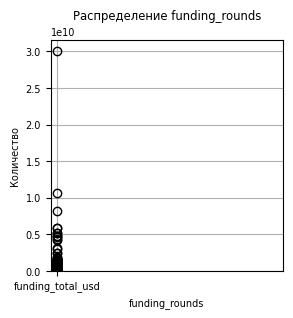

In [356]:
data_train['funding_rounds'].hist(bins=30)
plt.title('Распределение funding_rounds')
plt.xlabel('funding_rounds')
plt.ylabel('Количество')
plt.show()

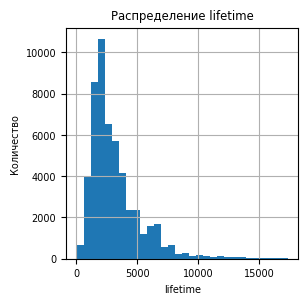

In [357]:
data_train['lifetime'].hist(bins=30)
plt.title('Распределение lifetime')
plt.xlabel('lifetime')
plt.ylabel('Количество')
plt.show()

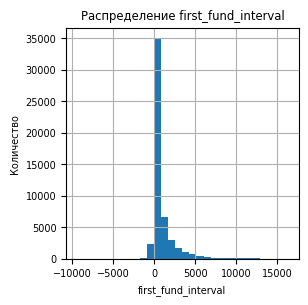

In [358]:
data_train['first_fund_interval'].hist(bins=30)
plt.title('Распределение first_fund_interval')
plt.xlabel('first_fund_interval')
plt.ylabel('Количество')
plt.show()

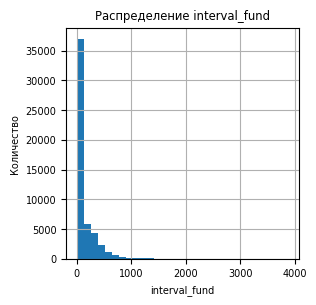

In [359]:
data_train['interval_fund'].hist(bins=30)
plt.title('Распределение interval_fund')
plt.xlabel('interval_fund')
plt.ylabel('Количество')
plt.show()

In [360]:
interval_cols = ['funding_total_usd','status','funding_rounds','lifetime','first_fund_interval','interval_fund']
cat_cols = list(set(data_train.columns)-set(interval_cols))

#sample_1000 = data_train.sample(n=1000)
#sample_1000.drop(['status'], axis= 1 , inplace= True)
phik_overview = data_train.phik_matrix(interval_cols=interval_cols)

In [361]:
cat_cols

['country_code']

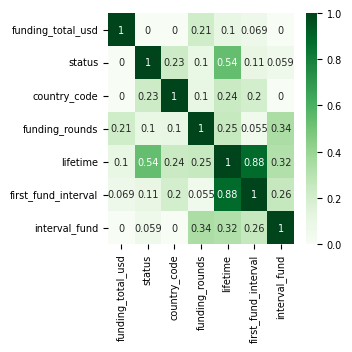

<Figure size 2000x2000 with 0 Axes>

In [362]:
sns.heatmap(phik_overview, 
            vmin=0, vmax=1,
            cmap="Greens",annot=True)
plt.figure(figsize=(20,20))
#plt.rcParams.update({'font.size': 7})
plt.show()

<div class="alert alert-info"> funding_total_usd совсем не коррелирует с целевым признаком - уберем его пока <div>

In [363]:
data_train.drop(['funding_total_usd'], axis= 1 , inplace= True)
data_test.drop(['funding_total_usd'], axis= 1 , inplace= True)

In [364]:
len(data_train)

52132

In [365]:
data_train = data_train.drop_duplicates()
len(data_train)

50767

In [366]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50767 entries, 0 to 52513
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   status               50767 non-null  int64  
 1   country_code         50767 non-null  object 
 2   funding_rounds       50767 non-null  int64  
 3   lifetime             50767 non-null  int32  
 4   first_fund_interval  50767 non-null  float64
 5   interval_fund        50767 non-null  float64
dtypes: float64(2), int32(1), int64(2), object(1)
memory usage: 2.5+ MB


In [367]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   country_code         13125 non-null  object 
 1   funding_rounds       13125 non-null  int64  
 2   lifetime             13125 non-null  int64  
 3   first_fund_interval  13125 non-null  float64
 4   interval_fund        13125 non-null  float64
dtypes: float64(2), int64(2), object(1)
memory usage: 512.8+ KB


## Построение модели

In [71]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

X = data_train.drop('status', axis = 1)
y = data_train['status']

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = TEST_SIZE, random_state = RANDOM_STATE, stratify = y)

In [78]:
label_encoder = LabelEncoder()
label_encoder.fit(y_train)

y_train = label_encoder.transform(y_train)
y_test = label_encoder.transform(y_test)

In [81]:
np.unique(y_train)

array([0, 1], dtype=int64)

In [82]:
ohe_columns = ['country_code']
num_columns = ['funding_rounds', 'lifetime', 'first_fund_interval', 'interval_fund']

In [84]:
#ohe_pipe=Pipeline([('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
#                 ('ohe', OneHotEncoder(sparse=False))])

ohe_pipe=Pipeline([('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                 ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop = 'first'))])

In [85]:
data_preprocessor=ColumnTransformer([('ohe',ohe_pipe,ohe_columns),
                                    ('num',StandardScaler(),num_columns)],
                                    remainder='passthrough')

In [86]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

In [187]:
param_grid = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(10, 20),
        'models__max_features': range(5, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE,solver='liblinear',penalty='l1')],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }#,
#    {
#        'models': [SVC(kernel = 'poly', probability=True, random_state=RANDOM_STATE)],
#        'models__degree': range(2, 5),
#        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
#    }
]

In [188]:
grid = GridSearchCV(
    pipe_final, 
    param_grid=param_grid, 
    cv=5, 
    scoring='f1', 
    n_jobs=-1,
    verbose=1)

In [189]:
#grid = RandomizedSearchCV(
#    pipe_final, 
#    param_grid=param_grid, 
#    cv=5, 
#    scoring='f1_weighted', 
#    random_state=RANDOM_STATE,
#    n_iter=50,
#    n_jobs=-1)

In [190]:
grid.fit(X_train, y_train)

Fitting 5 folds for each of 171 candidates, totalling 855 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('simpleImputer_ohe',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['country_code']),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         ['funding_rounds',
                                                                          'lifeti...
                                                MinMaxScaler(),
                                                'passthrough']},
                         {'models': [KNeighborsClassifier()],
                          'models__n_neighbors': range(2, 5),
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']},
                         {'models': [LogisticRegression(penalty='l1',
                                                        random_state=42,
                                                        solver='liblinear')],
                          'models__C': range(1, 5),
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']}],
             scoring='f1', verbose=1)

In [191]:
pd.set_option('display.max_colwidth', None)
result = pd.DataFrame(grid.cv_results_)
display(result[['rank_test_score', 'param_models', 'mean_test_score','params']].sort_values('rank_test_score')) 

,rank_test_score,param_models,mean_test_score,params
155,1,KNeighborsClassifier(),0.934084,"{'models': KNeighborsClassifier(), 'models__n_neighbors': 3, 'preprocessor__num': 'passthrough'}"
160,2,"LogisticRegression(penalty='l1', random_state=42, solver='liblinear')",0.932726,"{'models': LogisticRegression(penalty='l1', random_state=42, solver='liblinear'), 'models__C': 1, 'preprocessor__num': MinMaxScaler()}"
166,3,"LogisticRegression(penalty='l1', random_state=42, solver='liblinear')",0.930985,"{'models': LogisticRegression(penalty='l1', random_state=42, solver='liblinear'), 'models__C': 3, 'preprocessor__num': MinMaxScaler()}"
163,4,"LogisticRegression(penalty='l1', random_state=42, solver='liblinear')",0.930444,"{'models': LogisticRegression(penalty='l1', random_state=42, solver='liblinear'), 'models__C': 2, 'preprocessor__num': MinMaxScaler()}"
169,5,"LogisticRegression(penalty='l1', random_state=42, solver='liblinear')",0.930284,"{'models': LogisticRegression(penalty='l1', random_state=42, solver='liblinear'), 'models__C': 4, 'preprocessor__num': MinMaxScaler()}"
...,...,...,...,...
38,167,DecisionTreeClassifier(random_state=42),0.236572,"{'models': DecisionTreeClassifier(random_state=42), 'models__max_depth': 12, 'models__max_features': 7, 'preprocessor__num': 'passthrough'}"
37,167,DecisionTreeClassifier(random_state=42),0.236572,"{'models': DecisionTreeClassifier(random_state=42), 'models__max_depth': 12, 'models__max_features': 7, 'preprocessor__num': MinMaxScaler()}"
8,169,DecisionTreeClassifier(random_state=42),0.173234,"{'models': DecisionTreeClassifier(random_state=42), 'models__max_depth': 10, 'models__max_features': 7, 'preprocessor__num': 'passthrough'}"
7,169,DecisionTreeClassifier(random_state=42),0.173234,"{'models': DecisionTreeClassifier(random_state=42), 'models__max_depth': 10, 'models__max_features': 7, 'preprocessor__num': MinMaxScaler()}"


In [193]:
#dt = result[['param_models', 'mean_test_score', 'params']]
#dt[['param_models', 'params']] = dt[['param_models', 'params']].astype(str)
#a = dt[dt['param_models']=='DecisionTreeClassifier(random_state=42)']
#a.sort_values('mean_test_score', ascending = False).reset_index(drop=True)

In [266]:
y_test_pred = grid.predict(data_test)
len(y_test_pred)

D:\YP\practicum\practicum_env\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


13125

In [285]:
a = data_test_init['name']
a

0                    Crystalsol
1              JBI Fish & Wings
2                      COINPLUS
3        Imagine Communications
4                         DNA13
                  ...          
13120                     Jymob
13121                 GlobaTrek
13122                  Inkd.com
13123                    AdWill
13124               RingCentral
Name: name, Length: 13125, dtype: object

In [286]:
b = pd.DataFrame(y_test_pred)
b

,0
0,0
1,0
2,0
3,0
4,0
...,...
13120,0
13121,0
13122,0
13123,0


In [291]:
res = pd.concat([a, b], axis = 1)
res.columns = ['name', 'status']
res[res['status'] == 1]

,name,status
19,Solasta,1
31,thesweetlink,1
53,GammaSite,1
60,DashLuxe,1
80,Indie Broadcast Network,1
...,...,...
13054,NuFlick,1
13057,Macellum,1
13059,CostumeWorks,1
13073,i2we,1


In [292]:
res['status'] = res['status'].replace(0,'operating')
res['status'] = res['status'].replace(1, 'closed')

In [295]:
res.to_csv(r'C:\Users\betat\Downloads\res1.csv', index = False)

## Выводы

Данные состоят из 2 таблиц: 
- данные об истории стартапов
- данные для предсказания

На превом этапе была осуществлена предобработка данных:
- были проверены пропуски в таблицах и обнаруженные были заполнены медианными значениями (для интервальных признаков) и наиболее встречающимися (для категориальных)
- также не было обнаружено несочетающихся типов данных с содержанием столбцов
- категориальные признаки были переработаны:
    * удален столбец с наименованием, т.к. он мне несет смысловой нагрузки
    * на основании даты открытия и закрытия/выгрузки был сформирован столбец с продолжительностью жизни
    * столбцы с фондированием были препеработаны в интервальные пнризнаки как период до первого финансирования и средний период между финансированиями

На втором этапе был проведен статистический анализ данных:
- были выявлены что ни один из непрерывных столбцов не носит нормальный характер
- выбросов обнаружено не было

По результатам предварительного анализа было определено:
- нет никакой зависимости между целевым признаком и объемом фондирования (в итоге столбец с объемом фрондирования был удален)
- был построен Pipeline с моделями  KNeighborsClassifier, DecisionTreeClassifier, LogisticRegression

Отбор модели:
- среди всех построенных моделей лучшей оказалась KNeighborsClassifier('models__n_neighbors': 3, 'preprocessor__num': 'passthrough')
- Метрика F1 лучшей модели на тренировочной выборке: 0.93

Дальнейшие возможные шаги по улучшению модели:
- укрупнить country_code в части света